### Importing Packages

In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-24dc0ef39c96>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### Importing data

In [2]:
data = pd.read_csv('Real_Combine.csv')
data

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833
...,...,...,...,...,...,...,...,...,...
1088,18.1,24.0,11.2,1015.4,56.0,1.8,15.9,25.9,288.416667
1089,17.8,25.0,10.7,1015.8,54.0,2.3,9.4,22.2,256.833333
1090,13.9,24.5,11.4,1015.0,95.0,0.6,8.7,14.8,169.000000
1091,16.3,23.0,9.8,1016.9,78.0,1.1,7.4,16.5,186.041667


In [3]:
data.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

count    1092.000000
mean      109.090984
std        84.465790
min         0.000000
25%        41.833333
50%        83.458333
75%       158.291667
max       404.500000
Name: PM 2.5, dtype: float64

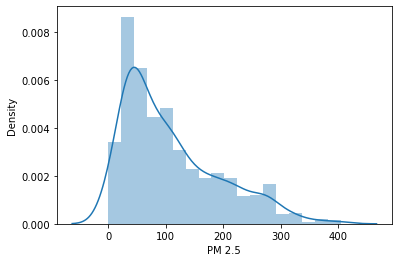

In [4]:
sns.distplot(data['PM 2.5'])
data['PM 2.5'].describe()

PM 2.5 field has only one null valye and we see that its distribution is skewed to the right. So it makes sense replacing the null with median.

In [5]:
data['PM 2.5'].replace(np.nan,data['PM 2.5'].median(), inplace = True)

In [6]:
data.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

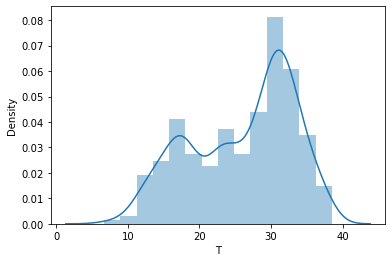

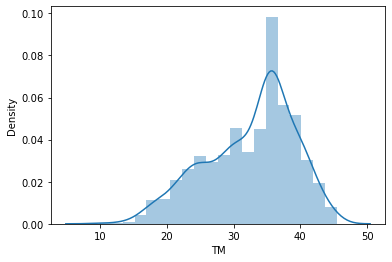

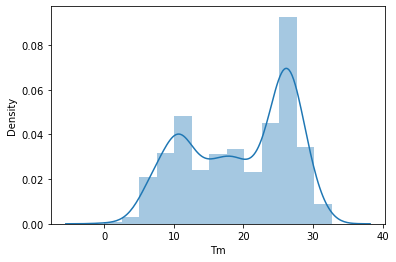

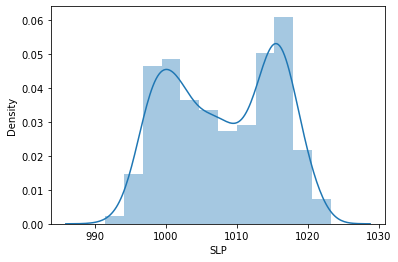

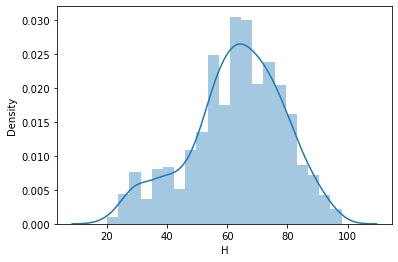

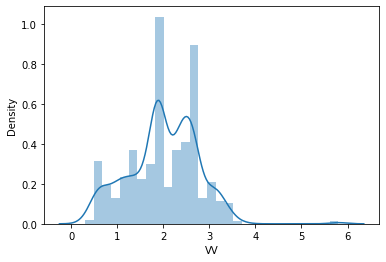

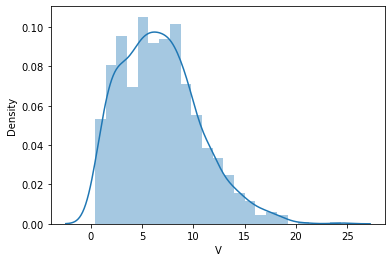

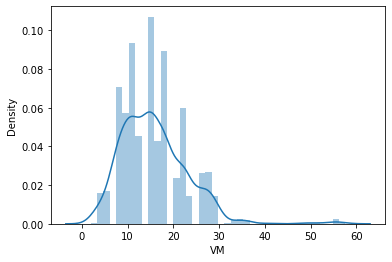

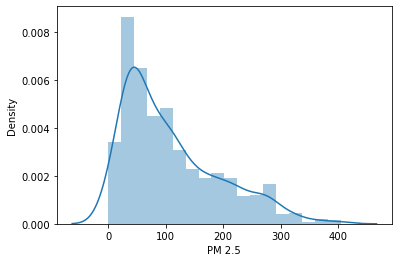

In [7]:
for field in list(data.columns):
    plt.figure()
    sns.distplot(data[field])

Looking at each distplot above, most of them appear to be skewed and some don't even follow normal distribution. So we will standardize all the independent variables before applying the model

### Splitting Data

In [8]:
X=data.iloc[:,:-1] ## independent features
y=data.iloc[:,-1] ## dependent features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Scaling Data

In [9]:
sc = StandardScaler()
X = sc.fit_transform(X)


### Hyperparameters

How many number of hidden layers we should have?

How many number of neurons we should have in hidden layers?

Learning Rate

In [10]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [11]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Air Quality Index')

INFO:tensorflow:Reloading Oracle from existing project project\Air Quality Index\oracle.json
INFO:tensorflow:Reloading Tuner from project\Air Quality Index\tuner0.json


In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 18
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [13]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary()

Results summary
Results in project\Air Quality Index
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 11
units_0: 96
units_1: 320
learning_rate: 0.001
units_2: 32
units_3: 352
units_4: 480
units_5: 384
units_6: 96
units_7: 128
units_8: 96
units_9: 192
units_10: 192
units_11: 96
units_12: 224
units_13: 256
units_14: 480
units_15: 352
Score: nan
Trial summary
Hyperparameters:
num_layers: 11
units_0: 160
units_1: 256
learning_rate: 0.0001
units_2: 64
units_3: 128
units_4: 160
units_5: 64
units_6: 192
units_7: 352
units_8: 448
units_9: 96
units_10: 128
units_11: 288
units_12: 448
units_13: 448
units_14: 416
units_15: 448
Score: nan
Trial summary
Hyperparameters:
num_layers: 16
units_0: 32
units_1: 192
learning_rate: 0.0001
units_2: 352
units_3: 288
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score: nan
Trial su